# COMP8220 Machine Learning Assessment Task 3



In [1]:
import os
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from functools import partial

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

keras.backend.clear_session()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Downloading and Preprocessing the Dataset

In this notebook, we will work with the Caltech-101 dataset which is composed of objects from 101 categories. We will exclude the top 5 most occurring categories from the dataset and use the remaining data to train a simple convolutional neural network (CNN) from scratch. We will also use the same dataset and use transfer learning to train a pretrained network, ResNet-50. In this section, we proceed by downloading and preprocessing the Caltech-101 dataset below.

In [2]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

######################################################################## 100.0%
101_ObjectCategories  cnn_drop.h5  cnn_nodrop.h5  sample_data


In [3]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/binocular', '101_ObjectCategories/grand_piano', '101_ObjectCategories/ibis', '101_ObjectCategories/minaret', '101_ObjectCategories/platypus', '101_ObjectCategories/rhino', '101_ObjectCategories/yin_yang', '101_ObjectCategories/llama', '101_ObjectCategories/anchor', '101_ObjectCategories/scorpion', '101_ObjectCategories/flamingo', '101_ObjectCategories/cougar_face', '101_ObjectCategories/beaver', '101_ObjectCategories/wild_cat', '101_ObjectCategories/saxophone', '101_ObjectCategories/revolver', '101_ObjectCategories/electric_guitar', '101_ObjectCategories/elephant', '101_ObjectCategories/inline_skate', '101_ObjectCategories/dollar_bill', '101_ObjectCategories/lamp', '101_ObjectCategories/brain', '101_ObjectCategories/joshua_tree', '101_ObjectCategories/hedgehog', '101_ObjectCategories/ceiling_fan', '101_ObjectCategories/starfish', '101_ObjectCategories/soccer_ball', '101_ObjectCategories/metronome', '101_ObjectCategories/watch', '101_ObjectCategories/ketch', '101_

This function is useful for pre-processing the data into an image and input vector.

In [0]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Load all the images from root folder.

In [0]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order.

In [0]:
random.shuffle(data)

Split the dataset to training / validation / test data (70%, 15%, 15%)

In [0]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [8]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[53, 62, 47, 22, 59, 91, 34, 96, 18, 19, 26, 9, 73, 72, 13, 37, 22, 9, 11, 33, 60, 86, 3, 30, 92, 95, 61, 17, 65, 18, 67, 75, 91, 96, 17, 84, 3, 9, 7, 60, 1, 70, 8, 92, 10, 7, 67, 61, 1, 21, 67, 53, 91, 39, 53, 16, 16, 89, 95, 72, 62, 67, 21, 72, 65, 24, 82, 26, 16, 76, 3, 28, 91, 57, 45, 57, 9, 55, 39, 9, 64, 33, 22, 67, 55, 48, 34, 96, 57, 91, 2, 19, 11, 89, 67, 85, 85, 83, 11, 1, 78, 91, 23, 28, 67, 83, 7, 12, 74, 78, 67, 11, 62, 77, 6, 12, 25, 6, 17, 93, 88, 93, 53, 64, 86, 12, 96, 7, 25, 90, 2, 35, 24, 74, 87, 55, 88, 80, 67, 41, 25, 80, 1, 11, 7, 27, 1, 48, 15, 57, 43, 25, 3, 62, 9, 31, 28, 41, 39, 68, 15, 17, 15, 67, 8, 25, 46, 3, 64, 77, 77, 88, 92, 67, 65, 88, 59, 95, 58, 78, 1, 71, 17, 16, 25, 2, 82, 68, 71, 20, 67, 7, 34, 56, 67, 5, 60, 73, 47, 18, 10, 91, 19, 71, 79, 72, 55, 9, 11, 22, 28, 28, 29, 69, 63, 36, 74, 23, 95, 60, 52, 29, 33, 62, 46, 44, 48, 22, 6, 59, 17, 55, 10, 28, 11, 3, 9, 41, 80, 55, 25, 43, 77, 65, 76, 44, 28, 89, 38, 19, 1, 52, 18, 16, 20, 60, 28, 22, 12,

Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [9]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


Let's get a summary of what we have.

In [10]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


Let's quickly look at a few sample images from our dataset.

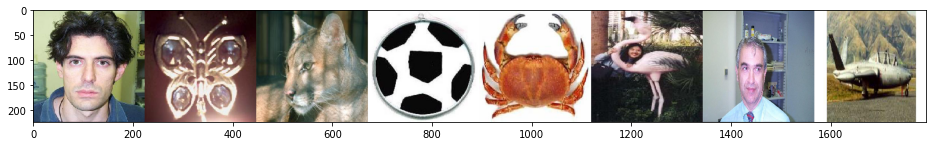

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Training Convolutional Neural Network from Scratch

Now that we have downloaded and preprocessed the Caltech-101 dataset, we can now use the data to train two simple CNNs from scratch. We will build two versions of CNNs: one without dropout layers and one with dropout layers. Both networks will have the same architecture so we can compare their performance against each other and see the effect of using dropout layers on a network. Our networks will have two convolution layers and two maxpooling layers.

### Building Convolutional Neural Network without Dropouts

We will build the CNN without dropout layers first. As mentioned above, the network will contain two convolution layers and two maxpooling layers.

Since we are working on small images only, we are going to use a small amount of filters. We would also like to identify small and local features on those images so we explore different options for the kernel size of the convolution layer and the pool size of the maxpool layer below:
* `kernel_size=(3, 3)` with `pool_size=(2, 2)`
* `kernel_size=(5, 5)` with `pool_size=(3, 3)`

We choose the `padding='same'` option to capture any important features that might sit on the border of our images. We proceed with creating the simple CNN with `kernel_size=(3, 3)`, `pool_size=(2, 2)` and two hidden layers. Due to computational limitations, the hidden layers will only have 512 neurons. The loss function will be `categorical_crossentropy` with the `Adam` optimizer with learning rate of 0.0003.

#### 3 by 3 Kernel Size

In [0]:
Dense_ = partial(keras.layers.Dense, activation='relu', kernel_initializer='he_normal')
Conv_ = partial(keras.layers.Conv2D, activation='relu', padding='same')
Maxpool_ = partial(keras.layers.MaxPooling2D, pool_size=(2, 2), padding='same')
Dropout_ = partial(keras.layers.Dropout, rate=0.5)

In [13]:
model_nodrop_3 = keras.models.Sequential([
                    Conv_(32, (3, 3), input_shape=x_train.shape[1:]),
                    Maxpool_(),
                    Conv_(64, (3, 3)),
                    Maxpool_(),
                    keras.layers.Flatten(),
                    Dense_(512),
                    Dense_(512),
                    Dense_(num_classes, activation='softmax',kernel_initializer='glorot_uniform')
])

model_nodrop_3.compile(loss='categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                       metrics=['accuracy'])

print("Input dimensions: ",x_train.shape[1:])
model_nodrop_3.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               102760960 
_________________________________________________________________
dense_2 (Dense)      

The network we constructed has 103 million parameters which may not be computationally efficient given the limitations of Colab. We train the model with `batch_size=128` and `epochs=100`. We also employ early stopping and checkpointing to stop the algorithm once we do not observe any significant change in the validation loss.

In [14]:
history_nodrop_3 = model_nodrop_3.fit(x_train, y_train, 
                                      batch_size=128, epochs=100, 
                                      validation_data=(x_val, y_val),
                                      callbacks=[keras.callbacks.ModelCheckpoint('cnn_nodrop.h5', save_best_only=True),
                                                 keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Train on 4346 samples, validate on 931 samples
Epoch 1/100
4346/4346 [==============================] - 8s 2ms/step - loss: 4.5401 - accuracy: 0.0792 - val_loss: 4.0009 - val_accuracy: 0.1493
Epoch 2/100
4346/4346 [==============================] - 5s 1ms/step - loss: 3.5269 - accuracy: 0.2338 - val_loss: 3.3456 - val_accuracy: 0.2932
Epoch 3/100
4346/4346 [==============================] - 6s 1ms/step - loss: 2.5403 - accuracy: 0.4225 - val_loss: 3.0330 - val_accuracy: 0.3416
Epoch 4/100
4346/4346 [==============================] - 5s 1ms/step - loss: 1.5880 - accuracy: 0.6454 - val_loss: 2.9044 - val_accuracy: 0.4017
Epoch 5/100
4346/4346 [==============================] - 5s 1ms/step - loss: 0.8892 - accuracy: 0.8132 - val_loss: 2.8097 - val_accuracy: 0.4017
Epoch 6/100
4346/4346 [==============================] - 5s 1ms/step - loss: 0.4083 - accuracy: 0.9225 - val_loss: 3.1591 - val_accuracy: 0.3727
Epoch 7/100
4346/4346 [==============================] - 5s 1ms/step - loss: 0.1808

In [15]:
loss_nodrop_3, accuracy_nodrop_3 = model_nodrop_3.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss_nodrop_3)
print('Test accuracy:', accuracy_nodrop_3)

Test loss: 3.067339804039493
Test accuracy: 0.3540772497653961


#### 5 by 5 Kernel Size
We now build a CNN with `kernel_size=(5, 5)` and `pool_size=(3, 3)` then compare its performance against the network above.

In [16]:
model_nodrop = keras.models.Sequential([
                  Conv_(32, (5, 5), input_shape=x_train.shape[1:]),
                  Maxpool_(pool_size=(3, 3)),
                  Conv_(64, (5, 5)),
                  Maxpool_(pool_size=(3, 3)),
                  keras.layers.Flatten(),
                  Dense_(512),
                  Dense_(512),
                  Dense_(num_classes, activation='softmax', kernel_initializer='glorot_uniform')
])

model_nodrop.compile(loss='categorical_crossentropy',
                     optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                     metrics=['accuracy'])

print("Input dimensions: ",x_train.shape[1:])
model_nodrop.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               20480512  
_________________________________________________________________
dense_5 (Dense)      

The network only contains 20.8 million trainable parameters, almost an 80% decrease compared to the network with `kernel_size=(3, 3)`. 

In [17]:
history_nodrop = model_nodrop.fit(x_train, y_train, 
                                  batch_size=128, 
                                  epochs=100, 
                                  validation_data=(x_val, y_val),
                                  callbacks=[keras.callbacks.ModelCheckpoint('cnn_nodrop.h5', save_best_only=True),
                                             keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Train on 4346 samples, validate on 931 samples
Epoch 1/100
4346/4346 [==============================] - 5s 1ms/step - loss: 4.2675 - accuracy: 0.1019 - val_loss: 3.7326 - val_accuracy: 0.2159
Epoch 2/100
4346/4346 [==============================] - 4s 912us/step - loss: 3.2395 - accuracy: 0.2814 - val_loss: 3.0733 - val_accuracy: 0.3405
Epoch 3/100
4346/4346 [==============================] - 4s 912us/step - loss: 2.3923 - accuracy: 0.4471 - val_loss: 2.8019 - val_accuracy: 0.3813
Epoch 4/100
4346/4346 [==============================] - 4s 915us/step - loss: 1.7078 - accuracy: 0.5838 - val_loss: 2.6258 - val_accuracy: 0.4189
Epoch 5/100
4346/4346 [==============================] - 4s 916us/step - loss: 1.0898 - accuracy: 0.7326 - val_loss: 2.6645 - val_accuracy: 0.4318
Epoch 6/100
4346/4346 [==============================] - 4s 912us/step - loss: 0.5734 - accuracy: 0.8642 - val_loss: 2.7809 - val_accuracy: 0.4672
Epoch 7/100
4346/4346 [==============================] - 4s 913us/step - 

In [18]:
loss_nodrop_train, accuracy_nodrop_train = model_nodrop.evaluate(x_train, y_train, verbose=0)
loss_nodrop_val, accuracy_nodrop_val = model_nodrop.evaluate(x_val, y_val, verbose=0)
loss_nodrop_test, accuracy_nodrop_test = model_nodrop.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss_nodrop_test)
print('Test accuracy:', accuracy_nodrop_test)

Test loss: 2.833567216928425
Test accuracy: 0.3744635283946991


In [0]:
nodrop_3 = pd.DataFrame(history_nodrop_3.history)
nodrop_3['category'] = 'no_dropout_3'
nodrop_3['epoch'] = range(len(nodrop_3))
nodrop = pd.DataFrame(history_nodrop.history)
nodrop['category'] = 'no_dropout_5'
nodrop['epoch'] = range(len(nodrop))

In [20]:
simple_cnn = nodrop_3.append(nodrop)
simple_cnn.epoch = simple_cnn.epoch + 1
simple_cnn.head()

,val_loss,val_accuracy,loss,accuracy,category,epoch
0,4.000906,0.149302,4.540120,0.079153,no_dropout_3,1
1,3.345588,0.293233,3.526884,0.233778,no_dropout_3,2
2,3.033037,0.341568,2.540289,0.422457,no_dropout_3,3
3,2.904409,0.401719,1.587993,0.645421,no_dropout_3,4
4,2.809665,0.401719,0.889192,0.813162,no_dropout_3,5


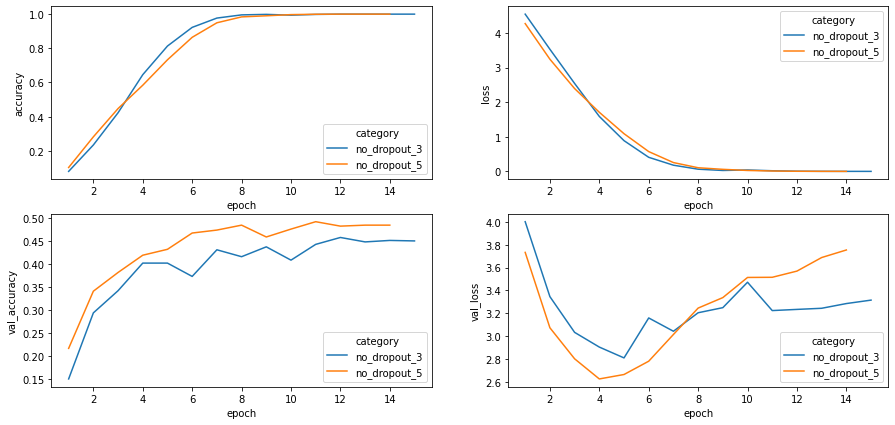

In [21]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,7))
sns.lineplot(x='epoch', y='accuracy', data=simple_cnn, hue='category', ax=axs[0, 0])
sns.lineplot(x='epoch', y='loss', data=simple_cnn, hue='category', ax=axs[0, 1])
sns.lineplot(x='epoch', y='val_accuracy', data=simple_cnn, hue='category', ax=axs[1, 0])
sns.lineplot(x='epoch', y='val_loss', data=simple_cnn, hue='category', ax=axs[1, 1])

Comparing the performance of the networks with no dropout layers and taking to account the computational capacity of Colab, we choose the network with `kernel_size=(5, 5)` and `pool_size=(3, 3)`. We will these parameters when building the network with dropouts below.

### Building Convolutional Neural Network with Dropouts
We replicate the architecture of the network with `kernel_size=(5, 5)` constructed above and insert three dropout layers, one layer will be placed before the flatten layer and two layers after it. For the dropout rate, we choose from [0.3, 0.4, 0.5, 0.6, 0.7] using `GridSearchCV()`.

In [0]:
def create_model(dropout=0.5):
  K.clear_session()
  model = keras.models.Sequential([
                Conv_(32, (5, 5), input_shape=x_train.shape[1:]),
                Maxpool_(pool_size=(3, 3)),
                Conv_(64, (5, 5)),
                Maxpool_(pool_size=(3, 3)),
                Dropout_(rate=dropout),
                keras.layers.Flatten(),
                Dense_(512),
                Dropout_(rate=dropout),
                Dense_(512),
                Dropout_(rate=dropout),
                Dense_(num_classes, activation='softmax', kernel_initializer='glorot_uniform')
  ])
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                metrics=['accuracy'])
  return model

**Note:** The cell below executes very slowly, so I recommend not running them at all. The result of the `GridSearchCV()` for the best dropout rate is 0.7.

In [0]:
model_drop = KerasClassifier(build_fn=create_model, verbose=0)
dropout_rate = [0.3, 0.4, 0.5, 0.6, 0.7]

grid = GridSearchCV(estimator=model_drop, param_grid=dict(dropout=dropout_rate), cv=3)
grid_result = grid.fit(x_train, y_train,
                       epochs=100, batch_size=128,
                       validation_data=(x_val, y_val),
                       callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('%f (%f) with : %r' % (mean, stdev, param))

Best: 0.468475 using {'dropout': 0.7}
0.420619 (0.011167) with : {'dropout': 0.3}
0.402440 (0.017592) with : {'dropout': 0.4}
0.429817 (0.010533) with : {'dropout': 0.5}
0.463646 (0.016344) with : {'dropout': 0.6}
0.468475 (0.011381) with : {'dropout': 0.7}


We train the network using the best dropout rate (`rate=0.7`) and the same parameters as the network with no dropouts executed earlier.

In [23]:
model_drop = create_model(dropout=0.7)

model_drop.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                   metrics=['accuracy'])

print("Input dimensions: ",x_train.shape[1:])
model_drop.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_1 (Dense)      

In [24]:
history_drop = model_drop.fit(x_train, y_train,
                              batch_size=128,
                              epochs=100,
                              validation_data=(x_val, y_val),
                              callbacks=[keras.callbacks.ModelCheckpoint('cnn_drop.h5', save_best_only=True),
                                         keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Train on 4346 samples, validate on 931 samples
Epoch 1/100
4346/4346 [==============================] - 4s 983us/step - loss: 4.6067 - accuracy: 0.0152 - val_loss: 4.5460 - val_accuracy: 0.0655
Epoch 2/100
4346/4346 [==============================] - 4s 925us/step - loss: 4.5436 - accuracy: 0.0315 - val_loss: 4.4769 - val_accuracy: 0.0709
Epoch 3/100
4346/4346 [==============================] - 4s 921us/step - loss: 4.4994 - accuracy: 0.0499 - val_loss: 4.4286 - val_accuracy: 0.0730
Epoch 4/100
4346/4346 [==============================] - 4s 971us/step - loss: 4.4382 - accuracy: 0.0621 - val_loss: 4.3073 - val_accuracy: 0.0784
Epoch 5/100
4346/4346 [==============================] - 4s 955us/step - loss: 4.3498 - accuracy: 0.0729 - val_loss: 4.1752 - val_accuracy: 0.1031
Epoch 6/100
4346/4346 [==============================] - 4s 961us/step - loss: 4.2571 - accuracy: 0.0918 - val_loss: 4.0948 - val_accuracy: 0.1375
Epoch 7/100
4346/4346 [==============================] - 4s 963us/step 

In [25]:
loss_drop_train, accuracy_drop_train = model_drop.evaluate(x_train, y_train, verbose=0)
loss_drop_val, accuracy_drop_val = model_drop.evaluate(x_val, y_val, verbose=0)
loss_drop_test, accuracy_drop_test = model_drop.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss_drop_test)
print('Test accuracy:', accuracy_drop_test)

Test loss: 2.2071807801467664
Test accuracy: 0.5096566677093506


### Comparison of the Two Simple Networks
We compare the historical runs of both networks with and without dropouts, as well as the training, validation and testing loss and accuracy of the two netwoks.

In [0]:
nodrop = pd.DataFrame(history_nodrop.history)
nodrop['category'] = 'no_dropout'
nodrop['epoch'] = range(len(nodrop))
drop = pd.DataFrame(history_drop.history)
drop['category'] = 'dropout'
drop['epoch'] = range(len(drop))

simple_cnn = nodrop.append(drop)
simple_cnn.epoch = simple_cnn.epoch + 1

In [0]:
def subset_df(df, cat1, cat2):
  data = df[[cat1, cat2, 'category', 'epoch']]
  data = pd.melt(data, id_vars=['category', 'epoch'])
  return data

def plot_line(df, cat1, cat2, cat3, x, y, hue, x0, y0):
  data = df[[cat1, cat2, 'category', 'epoch']]
  data = pd.melt(data, id_vars=['category', 'epoch'])
  ax = sns.lineplot(x=x, y=y,
                    data=data[data.category==cat3],
                    hue=hue, ax=axs[x0, y0])
  return ax

(-0.05, 1.05)

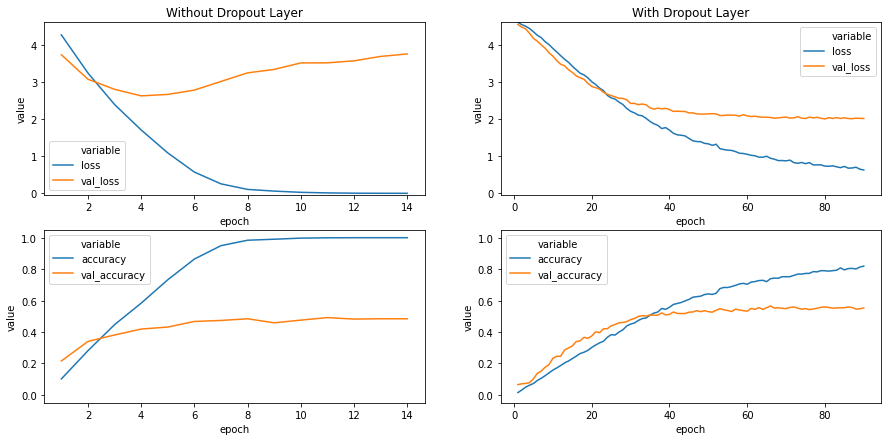

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,7))

ax1 = plot_line(simple_cnn, 'loss', 'val_loss', 'no_dropout', 'epoch', 'value', 'variable', 0, 0)
ax1.set_title('Without Dropout Layer')
ax1.set_ylim(-0.05, max(subset_df(simple_cnn, 'loss', 'val_loss').value))

ax2 = plot_line(simple_cnn, 'loss', 'val_loss', 'dropout', 'epoch', 'value', 'variable', 0, 1)
ax2.set_title('With Dropout Layer')
ax2.set_ylim(-0.05, max(subset_df(simple_cnn, 'loss', 'val_loss').value))

ax1 = plot_line(simple_cnn, 'accuracy', 'val_accuracy', 'no_dropout', 'epoch', 'value', 'variable', 1, 0)
ax1.set_ylim(-0.05, 1.05)

ax1 = plot_line(simple_cnn, 'accuracy', 'val_accuracy', 'dropout', 'epoch', 'value', 'variable', 1, 1)
ax1.set_ylim(-0.05, 1.05)

We can see that the network without dropout layers ran in less than 20 epochs, which means that we are not seeing any significant improvement in the validation loss in such a short amount of epochs. The validation loss has a steady decline up to the fourth epoch but started increasing again after which indicates that the network is getting less 'sure' of its prediction. We can also observe that the accuracy of the training data has reached 100% while the accuracy in the validation data is only around 40% which suggests that the network is severely overfitted.

The network with dropout layers, on the other hand, ran for almost 100 epochs, as expected since dropouts slows down the convergence of a network, with a steady decline in the validation loss. The accuracy in the training set is about 80% while the validation set has an accuracy of around 50%. This also suggests that the network is overfitting to our training data.

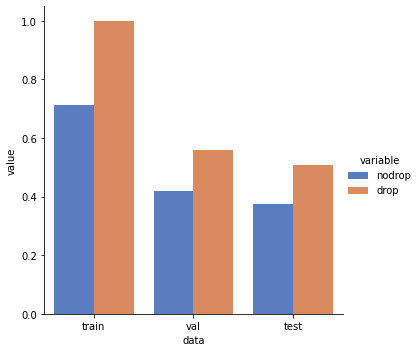

In [29]:
metrics_nodrop = [accuracy_nodrop_train, accuracy_nodrop_val, accuracy_nodrop_test]
metrics_drop = [accuracy_drop_train, accuracy_drop_val, accuracy_drop_test]
metrics_df = pd.DataFrame({'nodrop': metrics_nodrop, 'drop': metrics_drop})
metrics_df['data'] = ['train', 'val', 'test']
metrics_df = pd.melt(metrics_df, id_vars=['data'])

sns.catplot(x='data', y='value', hue='variable', data=metrics_df, kind='bar', palette='muted')

We also compare the best models chosen by the algorithm and their predictions on the training, validation and test data. We can see the overfitted nature of both networks. However, the network with dropout layers gives higher prediction accuracy than the network without dropout layers. This is expected since dropout layers train neurons such that they do not co-adapt with their neighboring neurons and learn as much as possible from all of their input neurons. This makes for a more robust network.

## Transfer Learning using ResNet-50
We now explore a transfer learning approach to classifying the images. For this task, we will utilize the ResNet-50 pretrained network. We will build two versions of the network using transfer learning method:

1. Re-training the last layer of ResNet-50
2. Re-training the last two layers of ResNet-50

We proceed with downloading the ResNet-50 network from keras below.

In [30]:
resnet50 = keras.applications.ResNet50V2()
resnet50.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### Unfreezing the last layer of ResNet-50
The ResNet-50 network contains more than 25 million trainable parameters, and multiple convolution and batch normalization layers. Before the output layer is a global average pooling layer and the final layer classifies 1,000 classes. We remove this final classification layer and replace it with a classifier of 97 classes to fit our dataset.

We implement transfer learning by creating a copy of ResNet-50 from its input layer until the second to last layer. Then, we create a dense layer, with 97 neurons corresponding to the classes in our dataset, that will serve as the ouput layer of our transfer learning network. We connect this layer to the second to the last layer of the ResNet-50 network (global average pooling layer).

In [0]:
# make a reference to ResNet50V2's input layer
inp = resnet50.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in ResNet50V2, and make a reference to it
out = new_classification_layer(resnet50.layers[-2].output)

# create a new network between inp and out
model_tl_v1 = Model(inp, out)

In [32]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_tl_v1.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_tl_v1.layers[-1:]):
    layer.trainable = True

model_tl_v1.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                    metrics=['accuracy'])
model_tl_v1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

We now have 198,753 parameters to train in the transfer learning network.

In [33]:
history_tl_v1 = model_tl_v1.fit(x_train, y_train, 
                                batch_size=128, 
                                epochs=100, 
                                validation_data=(x_val, y_val),
                                callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Train on 4346 samples, validate on 931 samples
Epoch 1/100
4346/4346 [==============================] - 16s 4ms/step - loss: 4.0661 - accuracy: 0.1392 - val_loss: 2.8724 - val_accuracy: 0.3577
Epoch 2/100
4346/4346 [==============================] - 12s 3ms/step - loss: 2.4587 - accuracy: 0.5345 - val_loss: 1.5425 - val_accuracy: 0.6896
Epoch 3/100
4346/4346 [==============================] - 12s 3ms/step - loss: 1.5187 - accuracy: 0.7715 - val_loss: 0.9611 - val_accuracy: 0.7938
Epoch 4/100
4346/4346 [==============================] - 12s 3ms/step - loss: 1.0108 - accuracy: 0.8629 - val_loss: 0.7145 - val_accuracy: 0.8367
Epoch 5/100
4346/4346 [==============================] - 12s 3ms/step - loss: 0.7317 - accuracy: 0.9128 - val_loss: 0.5830 - val_accuracy: 0.8593
Epoch 6/100
4346/4346 [==============================] - 12s 3ms/step - loss: 0.5675 - accuracy: 0.9337 - val_loss: 0.5141 - val_accuracy: 0.8679
Epoch 7/100
4346/4346 [==============================] - 12s 3ms/step - loss:

In [34]:
loss_tl_v1_train, accuracy_tl_v1_train = model_tl_v1.evaluate(x_train, y_train, verbose=0)
loss_tl_v1_val, accuracy_tl_v1_val = model_tl_v1.evaluate(x_val, y_val, verbose=0)
loss_tl_v1_test, accuracy_tl_v1_test = model_tl_v1.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss_tl_v1_test)
print('Test accuracy:', accuracy_tl_v1_test)

Test loss: 0.2880383698597486
Test accuracy: 0.9184549450874329


### Unfreezing the last two layers of ResNet-50
The last two layers of the ResNet-50 network are the global average pooling layer and the dense layer with 1,000 neurons. We now attach an intermediate dense layer between these two layers so that we are training two layers in this version of our transfer learning network. We create a dense layer with 1,024 neurons with the output of the second to the last layer (global average pooling layer) of ResNet-50 as its input, and the output of this new layer will then be used as the input of the last dense layer (classification layer) with 97 neurons.

In [0]:
# make a reference to ResNet50V2's input layer
inp = resnet50.input

# make a new dense layer with 1,024 neurons and softmax layer with num_classes neurons
new_dense_layer = Dense(1024, activation='relu')
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new dense layer to the second to last layer in ResNet50V2, and make a reference to it
out1 = new_dense_layer(resnet50.layers[-2].output)

# connect our softmax layer to the output of the layer above, and make a reference to it
out2 = new_classification_layer(out1)

# create a new network between inp and out2
model_tl_v2 = Model(inp, out2)

In [36]:
# make all layers untrainable by freezing weights (except for last 2 layers)
for l, layer in enumerate(model_tl_v2.layers[:-2]):
    layer.trainable = False

# ensure the last two layers are trainable/not frozen
for l, layer in enumerate(model_tl_v2.layers[-2:]):
    layer.trainable = True

model_tl_v2.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                    metrics=['accuracy'])
model_tl_v2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

We have over 2 million trainable parameters in our network corresponding to the parameters associated to the last 2 layers that we have attached to ResNet-50.

In [37]:
history_tl_v2 = model_tl_v2.fit(x_train, y_train, 
                                batch_size=128, 
                                epochs=100, 
                                validation_data=(x_val, y_val),
                                callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Train on 4346 samples, validate on 931 samples
Epoch 1/100
4346/4346 [==============================] - 14s 3ms/step - loss: 2.3682 - accuracy: 0.5421 - val_loss: 0.6904 - val_accuracy: 0.8271
Epoch 2/100
4346/4346 [==============================] - 12s 3ms/step - loss: 0.4608 - accuracy: 0.9006 - val_loss: 0.4343 - val_accuracy: 0.8765
Epoch 3/100
4346/4346 [==============================] - 12s 3ms/step - loss: 0.2107 - accuracy: 0.9565 - val_loss: 0.3755 - val_accuracy: 0.8980
Epoch 4/100
4346/4346 [==============================] - 12s 3ms/step - loss: 0.1151 - accuracy: 0.9841 - val_loss: 0.3572 - val_accuracy: 0.9033
Epoch 5/100
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0725 - accuracy: 0.9922 - val_loss: 0.3660 - val_accuracy: 0.9044
Epoch 6/100
4346/4346 [==============================] - 12s 3ms/step - loss: 0.0498 - accuracy: 0.9972 - val_loss: 0.3652 - val_accuracy: 0.9044
Epoch 7/100
4346/4346 [==============================] - 12s 3ms/step - loss:

In [38]:
loss_tl_v2_train, accuracy_tl_v2_train = model_tl_v2.evaluate(x_train, y_train, verbose=0)
loss_tl_v2_val, accuracy_tl_v2_val = model_tl_v2.evaluate(x_val, y_val, verbose=0)
loss_tl_v2_test, accuracy_tl_v2_test = model_tl_v2.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss_tl_v2_test)
print('Test accuracy:', accuracy_tl_v2_test)

Test loss: 0.31737600133830257
Test accuracy: 0.9163089990615845


### Comparison of the Two Transfer Learning Networks

In [0]:
one_train = pd.DataFrame(history_tl_v1.history)
one_train['category'] = 'train_one_layer'
one_train['epoch'] = range(len(one_train))
two_train = pd.DataFrame(history_tl_v2.history)
two_train['category'] = 'train_two_layers'
two_train['epoch'] = range(len(two_train))

tl_cnn = one_train.append(two_train)
tl_cnn.epoch = tl_cnn.epoch + 1

(-0.05, 1.05)

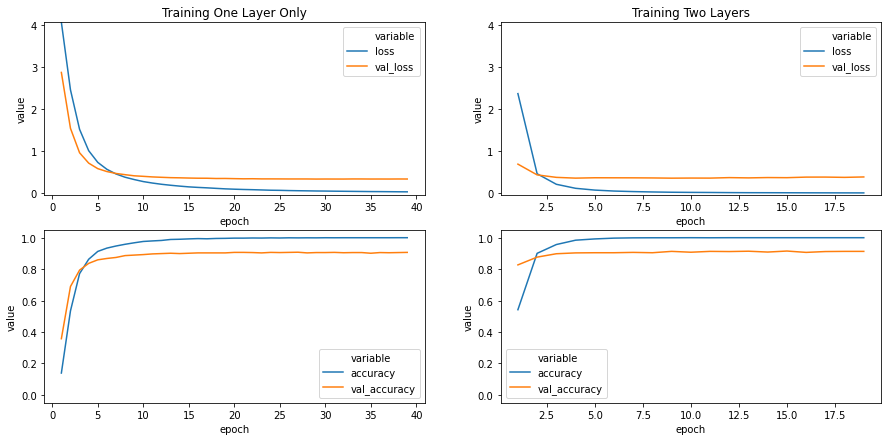

In [40]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,7))

ax1 = plot_line(tl_cnn, 'loss', 'val_loss', 'train_one_layer', 'epoch', 'value', 'variable', 0, 0)
ax1.set_title('Training One Layer Only')
ax1.set_ylim(-0.05, max(subset_df(tl_cnn, 'loss', 'val_loss').value))

ax2 = plot_line(tl_cnn, 'loss', 'val_loss', 'train_two_layers', 'epoch', 'value', 'variable', 0, 1)
ax2.set_title('Training Two Layers')
ax2.set_ylim(-0.05, max(subset_df(tl_cnn, 'loss', 'val_loss').value))

ax1 = plot_line(tl_cnn, 'accuracy', 'val_accuracy', 'train_one_layer', 'epoch', 'value', 'variable', 1, 0)
ax1.set_ylim(-0.05, 1.05)

ax1 = plot_line(tl_cnn, 'accuracy', 'val_accuracy', 'train_two_layers', 'epoch', 'value', 'variable', 1, 1)
ax1.set_ylim(-0.05, 1.05)

The first version of our transfer learning network ran for almost 40 epochs achieving 100% accuracy in the training data and more than 90% accuracy in the validation set. On the other hand, the second version of our transfer learning network ran in less than 20 epochs while reaching the same accuracy level in training and validation data as the first network. It is also worth noting that the loss and accuracy metrics started off better in the second version of our transfer learning network. This suggests that the convergence of a model may be improved as we increase the number of hidden layers in our network.

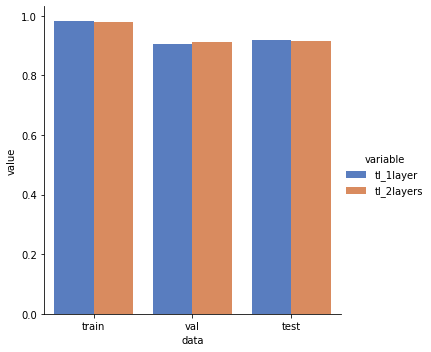

In [41]:
metrics_tl_v1 = [accuracy_tl_v1_train, accuracy_tl_v1_val, accuracy_tl_v1_test]
metrics_tl_v2 = [accuracy_tl_v2_train, accuracy_tl_v2_val, accuracy_tl_v2_test]
metrics_tl_df = pd.DataFrame({'tl_1layer': metrics_tl_v1, 'tl_2layers': metrics_tl_v2})
metrics_tl_df['data'] = ['train', 'val', 'test']
metrics_tl_df = pd.melt(metrics_tl_df, id_vars=['data'])

sns.catplot(x='data', y='value', hue='variable', data=metrics_tl_df, kind='bar', palette='muted')

As mentioned above, both transfer learning networks performed similarly in predicting the object classes. Their only difference is that the second version of our transfer learning network achieved this in less number of epochs.

## Comparison of Simple Networks against Transfer Learning Networks

(-0.05, 1.05)

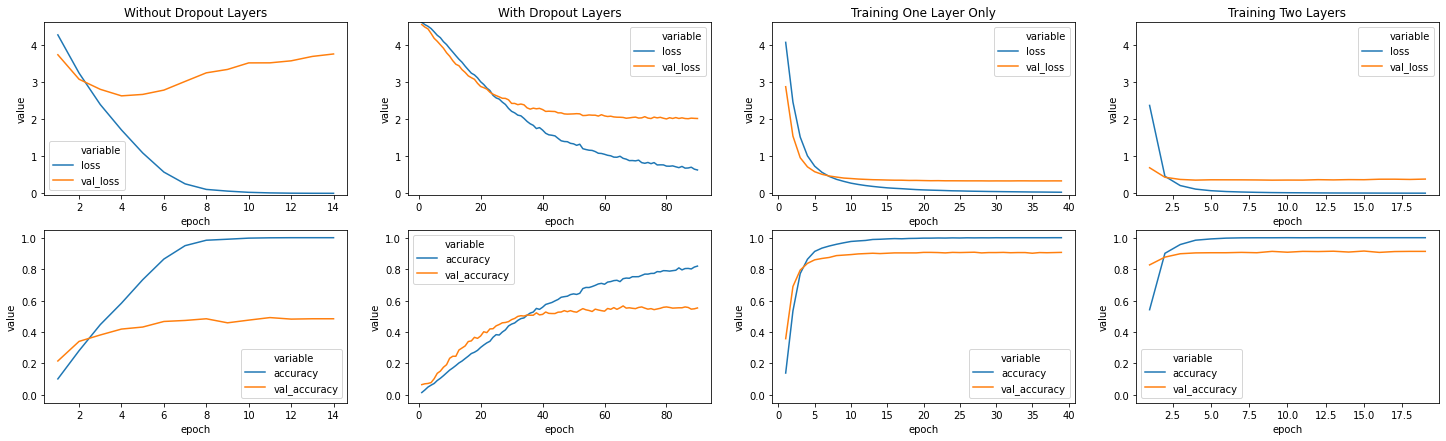

In [42]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(25,7))

all_cnn = simple_cnn.append(tl_cnn)

ax1 = plot_line(simple_cnn, 'loss', 'val_loss', 'no_dropout', 'epoch', 'value', 'variable', 0, 0)
ax1.set_title('Without Dropout Layers')
ax1.set_ylim(-0.05, max(subset_df(all_cnn, 'loss', 'val_loss').value))

ax2 = plot_line(simple_cnn, 'loss', 'val_loss', 'dropout', 'epoch', 'value', 'variable', 0, 1)
ax2.set_title('With Dropout Layers')
ax2.set_ylim(-0.05, max(subset_df(all_cnn, 'loss', 'val_loss').value))

ax1 = plot_line(simple_cnn, 'accuracy', 'val_accuracy', 'no_dropout', 'epoch', 'value', 'variable', 1, 0)
ax1.set_ylim(-0.05, 1.05)

ax1 = plot_line(simple_cnn, 'accuracy', 'val_accuracy', 'dropout', 'epoch', 'value', 'variable', 1, 1)
ax1.set_ylim(-0.05, 1.05)

ax5 = plot_line(tl_cnn, 'loss', 'val_loss', 'train_one_layer', 'epoch', 'value', 'variable', 0, 2)
ax5.set_title('Training One Layer Only')
ax5.set_ylim(-0.05, max(subset_df(all_cnn, 'loss', 'val_loss').value))

ax6 = plot_line(tl_cnn, 'loss', 'val_loss', 'train_two_layers', 'epoch', 'value', 'variable', 0, 3)
ax6.set_title('Training Two Layers')
ax6.set_ylim(-0.05, max(subset_df(all_cnn, 'loss', 'val_loss').value))

ax7 = plot_line(tl_cnn, 'accuracy', 'val_accuracy', 'train_one_layer', 'epoch', 'value', 'variable', 1, 2)
ax7.set_ylim(-0.05, 1.05)

ax8 = plot_line(tl_cnn, 'accuracy', 'val_accuracy', 'train_two_layers', 'epoch', 'value', 'variable', 1, 3)
ax8.set_ylim(-0.05, 1.05)

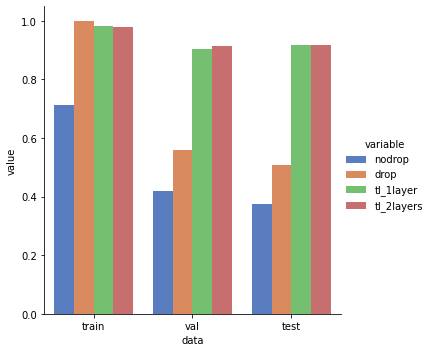

In [43]:
metrics_df = metrics_df.append(metrics_tl_df)

sns.catplot(x='data', y='value', hue='variable', data=metrics_df, kind='bar', palette='muted')

Generally, the transfer learning networks perform way better than the simple networks created in the first section of the notebook. This is expected since ResNet-50 has achieved 93% Top-5 Accuracy in the ImageNet dataset with 1,000 classes.

## Data Augmentation and Retraining ResNet-50
We now explore data augmentation methods to generate new datasets to train our transfer learning networks further. Since we are working on small images, we want to implement small shifts and changes to our original images. We also try to limit the image augmentations to the following so as to prevent Colab from crashing during the image generation process:
* rotation range of 10 degrees
* horizontal and vertical shifts of 10%
* zoom in at 90% and zoom out at 110%
* horizontal flip

In [0]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=(0.9, 1.1),
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
x_train_new = x_train
datagen.fit(x_train_new)

Retrain the first version of our transfer learning network above to the new set of images that we generated. Ensure that only the last layer is trainable.

In [46]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_tl_v1.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_tl_v2.layers[-1:]):
    layer.trainable = True

model_tl_v1.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                    metrics=['accuracy'])
model_tl_v1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [47]:
batch_size = 128
history_aug_v1 = model_tl_v1.fit(datagen.flow(x_train_new, y_train, batch_size),
                                    steps_per_epoch=len(x_train_new) / batch_size, epochs=100,
                                    validation_data=(x_val, y_val),
                                    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/100
34/33 [==============================] - 48s 1s/step - loss: 0.1671 - accuracy: 0.9735 - val_loss: 0.3422 - val_accuracy: 0.9098
Epoch 2/100
34/33 [==============================] - 44s 1s/step - loss: 0.1442 - accuracy: 0.9751 - val_loss: 0.3397 - val_accuracy: 0.9108
Epoch 3/100
34/33 [==============================] - 44s 1s/step - loss: 0.1289 - accuracy: 0.9779 - val_loss: 0.3311 - val_accuracy: 0.9119
Epoch 4/100
34/33 [==============================] - 44s 1s/step - loss: 0.1153 - accuracy: 0.9832 - val_loss: 0.3346 - val_accuracy: 0.9119
Epoch 5/100
34/33 [==============================] - 45s 1s/step - loss: 0.1046 - accuracy: 0.9848 - val_loss: 0.3340 - val_accuracy: 0.9098
Epoch 6/100
34/33 [==============================] - 46s 1s/step - loss: 0.0961 - accuracy: 0.9871 - val_loss: 0.3277 - val_accuracy: 0.9119
Epoch 7/100
34/33 [==============================] - 45s 1s/step - loss: 0.0891 - accuracy: 0.9869 - val_loss: 0.3366 - val_accuracy: 0.9108
Epoch 8/100
3

In [48]:
loss_aug_v1_train, accuracy_aug_v1_train = model_tl_v1.evaluate(x_train, y_train, verbose=0)
loss_aug_v1_val, accuracy_aug_v1_val = model_tl_v1.evaluate(x_val, y_val, verbose=0)
loss_aug_v1_test, accuracy_aug_v1_test = model_tl_v1.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss_aug_v1_test)
print('Test accuracy:', accuracy_aug_v1_test)

Test loss: 0.2659784704926444
Test accuracy: 0.9195278882980347


Now, we retrain the second version of our transfer learning network. Again, ensure that only the last two layers are trainable.

In [49]:
# make all layers untrainable by freezing weights (except for last 2 layers)
for l, layer in enumerate(model_tl_v2.layers[:-2]):
    layer.trainable = False

# ensure the last two layers are trainable/not frozen
for l, layer in enumerate(model_tl_v2.layers[-2:]):
    layer.trainable = True

model_tl_v2.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                    metrics=['accuracy'])
model_tl_v2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [50]:
history_aug_v2 = model_tl_v2.fit(datagen.flow(x_train_new, y_train, batch_size),
                                    steps_per_epoch=len(x_train_new) / batch_size, epochs=100,
                                    validation_data=(x_val, y_val),
                                    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/100
34/33 [==============================] - 48s 1s/step - loss: 0.1712 - accuracy: 0.9558 - val_loss: 0.4170 - val_accuracy: 0.9001
Epoch 2/100
34/33 [==============================] - 43s 1s/step - loss: 0.1053 - accuracy: 0.9742 - val_loss: 0.4103 - val_accuracy: 0.9033
Epoch 3/100
34/33 [==============================] - 45s 1s/step - loss: 0.0964 - accuracy: 0.9761 - val_loss: 0.3888 - val_accuracy: 0.9044
Epoch 4/100
34/33 [==============================] - 44s 1s/step - loss: 0.0799 - accuracy: 0.9793 - val_loss: 0.3812 - val_accuracy: 0.9119
Epoch 5/100
34/33 [==============================] - 45s 1s/step - loss: 0.0637 - accuracy: 0.9846 - val_loss: 0.4084 - val_accuracy: 0.9044
Epoch 6/100
34/33 [==============================] - 45s 1s/step - loss: 0.0590 - accuracy: 0.9860 - val_loss: 0.4130 - val_accuracy: 0.9066
Epoch 7/100
34/33 [==============================] - 45s 1s/step - loss: 0.0487 - accuracy: 0.9880 - val_loss: 0.4128 - val_accuracy: 0.9076
Epoch 8/100
3

In [51]:
loss_aug_v2_train, accuracy_aug_v2_train = model_tl_v2.evaluate(x_train, y_train, verbose=0)
loss_aug_v2_val, accuracy_aug_v2_val = model_tl_v2.evaluate(x_val, y_val, verbose=0)
loss_aug_v2_test, accuracy_aug_v2_test = model_tl_v2.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss_aug_v2_test)
print('Test accuracy:', accuracy_aug_v2_test)

Test loss: 0.3249804762395922
Test accuracy: 0.917382001876831


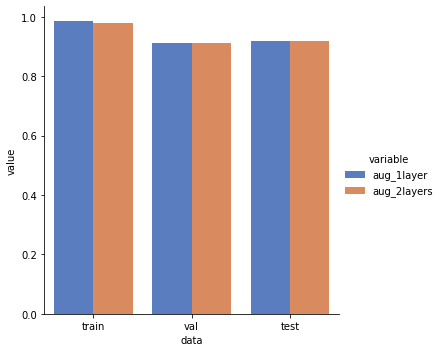

In [52]:
metrics_aug_v1 = [accuracy_aug_v1_train, accuracy_aug_v1_val, accuracy_aug_v1_test]
metrics_aug_v2 = [accuracy_aug_v2_train, accuracy_aug_v2_val, accuracy_aug_v2_test]
metrics_aug_df = pd.DataFrame({'aug_1layer': metrics_aug_v1, 'aug_2layers': metrics_aug_v2})
metrics_aug_df['data'] = ['train', 'val', 'test']
metrics_aug_df = pd.melt(metrics_aug_df, id_vars=['data'])

sns.catplot(x='data', y='value', hue='variable', data=metrics_aug_df, kind='bar', palette='muted')  

Comparing the performance of the networks after retraining them with the new generated images, not much have changed. The accuracy of the networks are still more than 90%.

In [0]:
aug_one_train = pd.DataFrame(history_aug_v1.history)
aug_one_train['category'] = 'aug_one_layer'
aug_one_train['epoch'] = range(len(aug_one_train))
aug_two_train = pd.DataFrame(history_aug_v2.history)
aug_two_train['category'] = 'aug_two_layers'
aug_two_train['epoch'] = range(len(aug_two_train))

aug_cnn = aug_one_train.append(aug_two_train)
aug_cnn.epoch = aug_cnn.epoch + 1

(-0.05, 1.05)

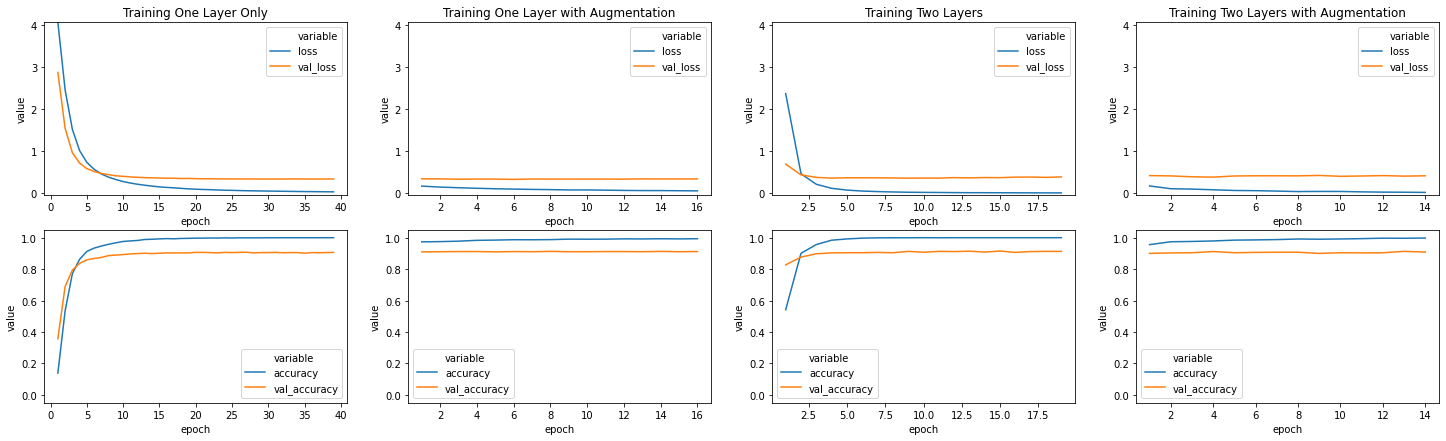

In [54]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(25,7))

all_tl_cnn = tl_cnn.append(aug_cnn)

ax1 = plot_line(tl_cnn, 'loss', 'val_loss', 'train_one_layer', 'epoch', 'value', 'variable', 0, 0)
ax1.set_title('Training One Layer Only')
ax1.set_ylim(-0.05, max(subset_df(all_tl_cnn, 'loss', 'val_loss').value))

ax2 = plot_line(tl_cnn, 'loss', 'val_loss', 'train_two_layers', 'epoch', 'value', 'variable', 0, 2)
ax2.set_title('Training Two Layers')
ax2.set_ylim(-0.05, max(subset_df(all_tl_cnn, 'loss', 'val_loss').value))

ax1 = plot_line(tl_cnn, 'accuracy', 'val_accuracy', 'train_one_layer', 'epoch', 'value', 'variable', 1, 0)
ax1.set_ylim(-0.05, 1.05)

ax1 = plot_line(tl_cnn, 'accuracy', 'val_accuracy', 'train_two_layers', 'epoch', 'value', 'variable', 1, 2)
ax1.set_ylim(-0.05, 1.05)

ax5 = plot_line(aug_cnn, 'loss', 'val_loss', 'aug_one_layer', 'epoch', 'value', 'variable', 0, 1)
ax5.set_title('Training One Layer with Augmentation')
ax5.set_ylim(-0.05, max(subset_df(all_tl_cnn, 'loss', 'val_loss').value))

ax6 = plot_line(aug_cnn, 'loss', 'val_loss', 'aug_two_layers', 'epoch', 'value', 'variable', 0, 3)
ax6.set_title('Training Two Layers with Augmentation')
ax6.set_ylim(-0.05, max(subset_df(all_tl_cnn, 'loss', 'val_loss').value))

ax7 = plot_line(aug_cnn, 'accuracy', 'val_accuracy', 'aug_one_layer', 'epoch', 'value', 'variable', 1, 1)
ax7.set_ylim(-0.05, 1.05)

ax8 = plot_line(aug_cnn, 'accuracy', 'val_accuracy', 'aug_two_layers', 'epoch', 'value', 'variable', 1, 3)
ax8.set_ylim(-0.05, 1.05)

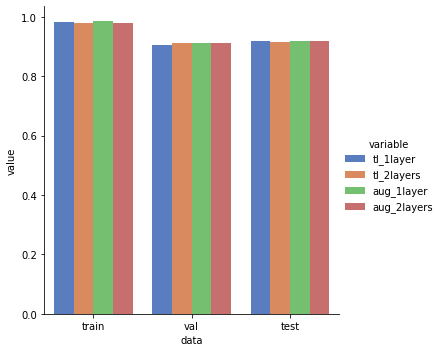

In [55]:
metrics_tl = metrics_tl_df.append(metrics_aug_df)
sns.catplot(x='data', y='value', hue='variable', data=metrics_tl, kind='bar', palette='muted') 

Lastly, comparing the networks from the transfer learning ran from the previous section against the updated transfer learning networks we just ran, we can see that there is no siginificant improvement in terms of the networks' accuracy.